In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


import hydra
from typing import Optional
from collections.abc import Callable
from omegaconf import OmegaConf, DictConfig

from data_module.lightning_data_module import DataModule
from hydra import initialize, initialize_config_module, initialize_config_dir, compose

In [30]:
mapping = {0: (255, 153, 51),
            1: (0, 128, 255),
            2: (0, 0, 255)}
            
def vis_gt(bev):
    # bev = np.transpose(bev, (1, 2, 0))
    area = bev[:,:,0] + bev[:,:,1]
    divider = bev[:,:,2] + bev[:,:,3]
    vehicle = bev[:,:,4] + bev[:,:,5] + bev[:,:,6] + bev[:,:,7]

    h, w = area.shape
    vis = np.full((h, w, 3), 255, dtype='uint8')

    
    for i, bibev in enumerate([area, divider, vehicle]):
    # for i, bibev in enumerate([area, vehicle]):
        vis[bibev!=0,:] = mapping[i]
    
    vis[95:105, 98:102, :] = (255, 0, 0)

    # plt.imshow(vis)
    # plt.axis('off')
    # plt.savefig('/home/miruware/ws/bevtransformer/scripts/gts.png')

    return vis
    
def setup(cfg):

    cfg.loader.batch_size = 1

    if 'split' not in cfg:
        cfg.split = 'val'

    if 'shuffle' not in cfg:
        cfg.shuffle = False
        
def setup_config(cfg: DictConfig, override: Optional[Callable] = None):

    OmegaConf.set_struct(cfg, False)
    OmegaConf.resolve(cfg)
    OmegaConf.set_struct(cfg, True)


def merge_rgbs(imgs):

    fl = np.transpose(imgs[0], (1,2,0))
    ff = np.transpose(imgs[1], (1,2,0))
    fr = np.transpose(imgs[2], (1,2,0))

    front = np.hstack([fl, ff, fr])

    bl = np.transpose(imgs[5], (1,2,0))
    bf = np.transpose(imgs[4], (1,2,0))
    br = np.transpose(imgs[3], (1,2,0))

    back = np.hstack([bl, bf, br])

    whole = np.vstack([front, back])

    return whole

In [23]:

# *  config setup  * #
CONFIG_PATH = '/usr/src/CV_For_Autonomous_Driving/config'

with initialize_config_dir(config_dir=CONFIG_PATH):
    cfg = compose(config_name='default_config.yaml')
    
setup_config(cfg, setup)


# dataset list 만드는 test
DM = DataModule(cfg.data, cfg.loader)

split = 'train'
data_cfg = DM.data_cfg
datasets = DM.get_datasets(split=split,
                            **data_cfg)

print(f'In {split} dataset, {len(datasets)} scenes are included.')


# dataset init test
total = 0
for dataset in datasets:
    total += len(dataset)

print(f'nuscenes train has {total} data samples')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'default_config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 42.487 seconds.
Reverse indexing ...
Done reverse indexing in 11.0 seconds.
In train dataset, 700 scenes are included.
nuscenes train has 28130 data samples


In [25]:
# dataset __getitem__ test
data = datasets[0].__getitem__(10)
for k, v in data.items():
    print(f'{k}: {v.shape}')

bev [  0 255]
center [0.00000000e+00 3.03877680e-28 3.39951841e-28 6.27714765e-27
 6.63927679e-27 1.75483064e-26 1.26139524e-25 1.41113904e-25
 3.37407198e-25 2.60564169e-24 2.75596189e-24 7.03426717e-24
 7.28429663e-24 8.30751502e-23 5.46216732e-22 6.11059685e-22
 6.29284265e-22 2.76820940e-21 6.91832942e-21 7.61878904e-21
 1.12831030e-20 1.19340271e-20 1.24835400e-20 3.15428848e-20
 8.17059218e-20 9.33043317e-20 1.01491675e-19 1.13540052e-19
 1.80631262e-19 6.18912561e-19 1.08893034e-18 1.94520889e-18
 2.09649567e-18 2.21744271e-18 2.72258413e-18 5.86093446e-18
 7.30934261e-18 7.49321824e-18 9.15053333e-18 1.22777889e-17
 2.29730473e-17 5.82089776e-17 6.27354026e-17 6.40770366e-17
 8.02177656e-17 1.32874707e-16 1.48648644e-16 1.74018062e-16
 5.10286582e-16 5.49967217e-16 6.62704231e-16 7.65502109e-16
 2.10684919e-15 2.74476897e-15 2.90311543e-15 3.45211475e-15
 3.49188761e-15 7.67323843e-15 7.82660984e-15 1.10515294e-14
 1.23634394e-14 1.29598404e-14 5.44090529e-14 5.92855165e-14
 7.

### Visualization

In [26]:
# imgs = data['image'].squeeze(0).numpy()   # 6 3 224 480
# gts = data['bev'].squeeze(0).numpy()      # 12 200 200
imgs = data['image'].numpy()   # 6 3 224 480
gts = data['bev'].numpy()      # 12 200 200

stacked_imgs = merge_rgbs(imgs)

gt_maps = vis_gt(gts)                           # 200 200 3
gt_maps = cv2.resize(gt_maps, (448, 448))       # 448 448 3

print('stacked rgb images shape: ', stacked_imgs.shape)
print('ground truth shape: ', gt_maps.shape)

(-0.5, 1887.5, 447.5, -0.5)

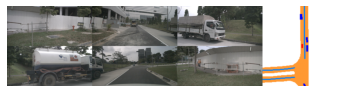

In [32]:

whole = np.hstack([stacked_imgs, gt_maps/255.0])      # 448 1888 3

plt.imshow(whole)
plt.axis('off')
